In [282]:
import random
import math

import matplotlib.pyplot as plt
import numpy as np

In [283]:
GROUP_ID = "04"
ALG = "QLearning"
TRACK_NAME = "tracks/2-track.txt"
CRASH_POS = "FRST"

In [284]:
def bresenhamsAlgorithm(x1, x2, y1, y2):
    dx = math.fabs(x1 -x2)
    dy = math.fabs(y1-y2)
    sx = (-1 if x2-x1 <0 else 1)
    sy = (-1 if y2-y1 <0 else 1)
    err = dx-dy
    p = 2* (dx-dy)
    linePoints = []
    while True:
        linePoints.append((x1, y1))
        if(x1 == x2 and y1 == y2):
            break
        e2 = 2 * err
        if e2 > -dy:
            err = err -dy
            x1 = x1 +sx
        if e2 < dx:
            err = err +dx
            y1 = y1 + sy

    return linePoints


In [285]:
print(bresenhamsAlgorithm(2,3,2,3))

[(2, 2), (3, 3)]


In [286]:
def makePlot(track):
    rows = track.size[1]
    cols = track.size[0]

    coloring = np.zeros((rows,cols,3))
    for y in range(rows):
        for x in range(cols):
            if track.array[x][y] == '.':
                coloring[y,x] = [1,1,1]
            elif track.array[x][y] == 'S':
                coloring[y,x] = [0,1,0]
            elif track.array[x][y] == 'F':
                coloring[y,x] = [1,0,0]
            else:
                coloring[y,x] = [0,0,0]

    plt.axis('off')
    plt.imshow(coloring)
    return plt


In [287]:
class RaceTrack:
    def __init__(self, file):
        with(open(file , "r") as f):
            lines = f.readlines()
            dims = lines[0]
            self.size = [0,0]
            self.size[0] = int(dims.split(",")[1].strip("\n"))
            self.size[1] = int(dims.split(",")[0])
            self.array = [[_ for y in range(self.size[1])] for x in range(self.size[0])]
            self.startStates = []
            self.finishStates = []
            self.walls = []
            self.track = []
            yIndex = 0
            for line in lines[1:]:
                xIndex = 0
                for char in line[:-1]:
                    if(char == "S"):
                        self.startStates.append((xIndex, yIndex))
                    elif(char == "F"):
                        self.finishStates.append((xIndex, yIndex))
                    elif(char == "#"):
                        self.walls.append((xIndex, yIndex))
                    else:
                        self.track.append((xIndex, yIndex))
                    self.array[xIndex][yIndex] = char
                    xIndex += 1
                yIndex += 1

    #prints track with car to command line, used for testing
    def printTrack(self, car):
        print("\n")
        for y in range(self.size[1]):
            line = ''
            for x in range(self.size[0]):
                if(car.xPos == x and car.yPos == y):
                    line += "C"
                else:
                    line += self.array[x][y]
            print(line)


In [288]:
class Car:
    def __init__(self, racetrack):
        self.startState = random.choice(racetrack.startStates)
        self.xPos = self.startState[0]
        self.yPos = self.startState[1]
        self.xVel = 0
        self.yVel = 0
        self.xAccel = 0
        self.yAccel = 0
        self.track = racetrack
        self.timeSteps = 0

    def updatePos(self, xAccel, yAccel, resetAfter):
        iXpos = self.xPos
        iYpos = self.yPos
        iXvel = self.xVel
        iYvel = self.yVel
        iXAcc = self.xAccel
        iYAcc = self.yAccel
        #print("xPos:", self.xPos, "yPos:", self.yPos, "\nxVel:", self.xVel, "yVel:", self.yVel, "\nxAccel:", xAccel, "yAccel:", yAccel )
        #accounting for oil slicks in the track
        randomNum = random.uniform(0,1)
        if(randomNum <= 0.2):
            oilSlick = True
        else:
            oilSlick = False
        if(oilSlick):
            self.xAccel = 0
            self.yAccel = 0
        else:
            self.xAccel = xAccel
            self.yAccel = yAccel
        self.xVel += self.xAccel
        self.yVel += self.yAccel
        if(self.xVel > 5):
            self.xVel = 5
        if(self.xVel < -5):
            self.xVel = -5
        if(self.yVel > 5):
            self.yVel = 5
        if(self.yVel < -5):
            self.yVel = -5
        self.xPos += self.xVel
        self.yPos += self.yVel
        #checking if the car collided with a wall
        carCourse = bresenhamsAlgorithm(iXpos, self.xPos, iYpos, self.yPos)
        crashed = False
        finished = False
        for i in range(len(carCourse)):
            pos = carCourse[i]
            #crash
            if(pos in self.track.walls):
                crashed = True
                nearestPoint = carCourse[i-1]
                break
            if(pos in self.track.finishStates):
                finished = True
                finishPoint = pos
        if(crashed):
            self.resetCar()
            if(CRASH_POS == "NRST"):
                self.xPos = nearestPoint[0]
                self.yPos = nearestPoint[1]
            # else:
            #     # print("Fully reset")
        if(finished):
            self.resetCar()
            self.xPos = finishPoint[0]
            self.yPos = finishPoint[1]
            # print("Finished the race!")
        if(resetAfter):
            self.xPos = iXpos
            self.yPos = iYpos
            self.xVel = iXvel
            self.yVel = iYvel
            self.xAccel = iXAcc
            self.yAccel = iYAcc


    def resetCar(self):
        self.xVel = 0
        self.yVel = 0
        self.xAccel = 0
        self.yAccel = 0
        self.xPos = self.startState[0]
        self.yPos = self.startState[1]
        #print("xPos:", self.xPos, "yPos:", self.yPos, "\nxVel:", self.xVel, "yVel:", self.yVel, "\nxAccel:", self.xAccel, "yAccel:", self.yAccel)


In [289]:
def qLearning(learningRate, discountFactor, epochs, explorationDecay, racetrack, min):
    car = Car(racetrack)
    possibleStates = racetrack.startStates + racetrack.track + racetrack.finishStates
    possibleActions = []
    startState = car.startState
    for xA in [-1,0,1]:
        for yA in [-1,0,1]:
            possibleActions.append((xA, yA))
    qTable = np.zeros((len(possibleStates), len(possibleActions)))
    counterArr = []
    epochArr = []
    explorationProb = 1
    name = "qLearning_L=" + str(learningRate) + "_D="+ str(discountFactor) + "_E=" + str(explorationProb) + "_epochs=" + str(epochs) + ".png"
    bestVal = car.startState[0] + car.startState[1]
    print(bestVal)
    for epoch in range(epochs):
        print(epoch)
        if(explorationProb >= min):
            explorationProb *= explorationDecay
        if(learningRate >= min):
            learningRate *= 0.999
        car.resetCar()
        currentState = possibleStates.index(startState)
        counter = 0
        while True:
            counter += 1
            if(random.uniform(0,1) < explorationProb):
                actionChosenIndex = random.randint(0, len(possibleActions)-1)
            else:
                actionChosenIndex = np.argmax(qTable[currentState])
            actionChosen = possibleActions[actionChosenIndex]
            car.updatePos(actionChosen[0],actionChosen[1], False)
            carState = (car.xPos, car.yPos)
            if(car.xPos + car.yPos > bestVal):
                print("Best x and y:", car.xPos, car.yPos)
                bestVal = car.xPos + car.yPos
            nextState = possibleStates.index(carState)
            if(carState in racetrack.finishStates):
                reward = 0
            else:
                reward = -1
            qTable[currentState][actionChosenIndex] += learningRate * (reward + discountFactor * np.max(qTable[nextState]) - qTable[currentState][actionChosenIndex])
            currentState = nextState
            if(carState in racetrack.finishStates):
                break
        #print("In", counter, "steps")
        counterArr.append(counter)
        epochArr.append(epoch)
    # plt.plot(epochArr, counterArr)
    # plt.xlabel("Epochs")
    # plt.ylabel("Steps")
    # plt.savefig(name)



    #running the actual agent
    car.resetCar()
    x_coord = [c.xPos]
    y_coord = [c.yPos]
    currentState = possibleStates.index(startState)
    timeRace = 0
    while True:
        timeRace += 1
        actionChosenIndex = np.argmax(qTable[currentState])
        actionChosen = possibleActions[actionChosenIndex]
        car.updatePos(actionChosen[0],actionChosen[1], False)
        x_coord.append(car.xPos)
        y_coord.append(car.yPos)
        carState = (car.xPos, car.yPos)
        nextState = possibleStates.index(carState)
        currentState = nextState
        if(carState in racetrack.finishStates):
            break

    #graph = makePlot(r)
    #graph.plot(x_coord,y_coord,linestyle = '-', color = 'blue')
    #graph.show()
    return timeRace, x_coord, y_coord



In [ ]:
r = RaceTrack(TRACK_NAME)
r2 = RaceTrack(TRACK_NAME)
c = Car(r)
x_coord = [c.xPos]
y_coord = [c.yPos]
#graph = makePlot(r)
#r.printTrack(c)
avg = 0
bestTime = None
worstTime = None
for i in range(5):
    t, xCord, yCord = qLearning(0.1, .999999, 2500, 1.2, r, 0.05)
    print(t)
    avg+= t
    if((bestTime == None) or t < bestTime):
                    bestTime = t
                    x_coord = xCord
                    y_coord = yCord
    if((worstTime == None) or t > worstTime):
                    worstTime = t
                    x_coord2 = xCord
                    y_coord2 = yCord

avg/= 5
graph = makePlot(r)
graph.plot(x_coord,y_coord,linestyle = '-', color = 'blue')
graph.savefig("results/"+ALG+"_"+TRACK_NAME.split("/")[1]+"_"+CRASH_POS +"_BEST"+ ".png")
print(bestTime)
print(worstTime)
print(avg)

12
0
Best x and y: 5 8
Best x and y: 13 2
Best x and y: 16 1
Best x and y: 19 1
Best x and y: 18 4
Best x and y: 21 2
Best x and y: 21 3
Best x and y: 22 4
Best x and y: 23 5
Best x and y: 23 7
Best x and y: 24 7


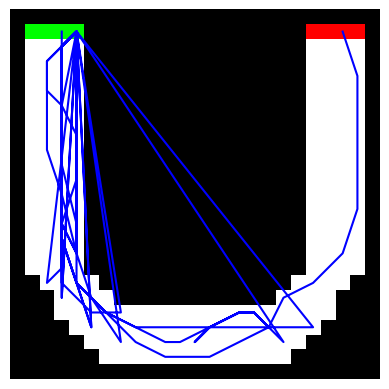

In [163]:
graph2 = makePlot(r2)
graph2.plot(x_coord2,y_coord2,linestyle = '-', color = 'blue')
graph2.savefig("results/"+ALG+"_"+TRACK_NAME.split("/")[1]+"_"+CRASH_POS +"_WORST"+ ".png")

In [162]:
# while True:
#     userInput = input("Enter xAccel and yAccel: ")
#     xA = int(userInput.split(",")[0]) + x_coord[len(x_coord)-1]
#     yA = int(userInput.split(",")[1]) + y_coord[len(y_coord)-1]
#     x_coord.append(xA)
#     y_coord.append(yA)
#     c.updatePos(xA, yA)
#     graph = makePlot(r)
#     graph.plot(x_coord,y_coord,linestyle = '-', color = 'blue')
#     graph.show()
#     r.printTrack(c)